# CNN 심화

## [예제5] InceptionV3 Fine Tungin

>### Load modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.18.5
TensorFlow Version :2.3.0
Matplotlib Version :3.2.2


> ### Import Keras Layers

In [2]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

> ### Load Inception Model

In [3]:
IMG_SIZE = 224

In [4]:
from tensorflow.keras.applications import InceptionV3

model = InceptionV3(
    weights="imagenet", 
    include_top=False, # 최상위의 Dense layer 포함 여부 설정
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    )
 
model.summary()

87916544/87910968 [==============================] - 4s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

> ### Set trainable option

In [5]:
for layer in model.layers[:-31]:
    layer.trainable = False
 
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f15cb3d8278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15cb3e3cf8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f15cb3e1080> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f15cb3e1898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f15cb3e1550> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f158dfd3be0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f158dfd3f60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f158dfd9198> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f158dff5518> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f158dff58d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f158dff5908> False
<tensorflow.python.keras.layers.c

> ### Layer를 추가하여 모델 완성

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model_fine = tf.keras.models.Sequential()

model_fine.add(model)

model_fine.add(GlobalAveragePooling2D())
model_fine.add(Dense(5, activation='softmax'))

model_fine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 6,083,781
Non-trainable params: 15,729,248
_________________________________________________________________


> ### Download Data

In [7]:
import pathlib
data_dir = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
print (data_dir)

228818944/228813984 [==============================] - 5s 0us/step
/root/.keras/datasets/flower_photos


> ### Check Data

In [8]:
def check_dir(d_path):
  img_count = len(list(d_path.glob('*/*.jpg')))
  c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
  return img_count, c_name, len(c_name)

In [9]:
image_count, CLASS_NAMES, class_num = check_dir(data_dir)

print('image_count: {}\nclasses: {}\nclass num: {}'.format(image_count, CLASS_NAMES, class_num))

image_count: 3670
classes: ['tulips' 'daisy' 'dandelion' 'roses' 'sunflowers']
class num: 5


> ### ImageDataGenerator

In [10]:
BATCH_N = 128

In [11]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True, 
        vertical_flip=True,
        validation_split=0.2,
        rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
                      directory=str(data_dir),
                      batch_size=BATCH_N,
                      target_size=(IMG_SIZE, IMG_SIZE),
                      classes = list(CLASS_NAMES),
                      class_mode = 'sparse',
                      subset='training'
                      )

test_data_gen = image_gen.flow_from_directory(
                      directory=str(data_dir),
                      batch_size=BATCH_N,
                      target_size=(IMG_SIZE, IMG_SIZE),
                      classes = list(CLASS_NAMES),
                      class_mode = 'sparse',
                      subset='validation'
                      )

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


> ### 이미지를 그리는 함수

In [12]:
def Plot_Images(suptitle, data, label):
    fig_result, ax_result = plt.subplots(2, 5, figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx],cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {})".format(idx, label[idx]))

> ### 학습할 이미지 확인

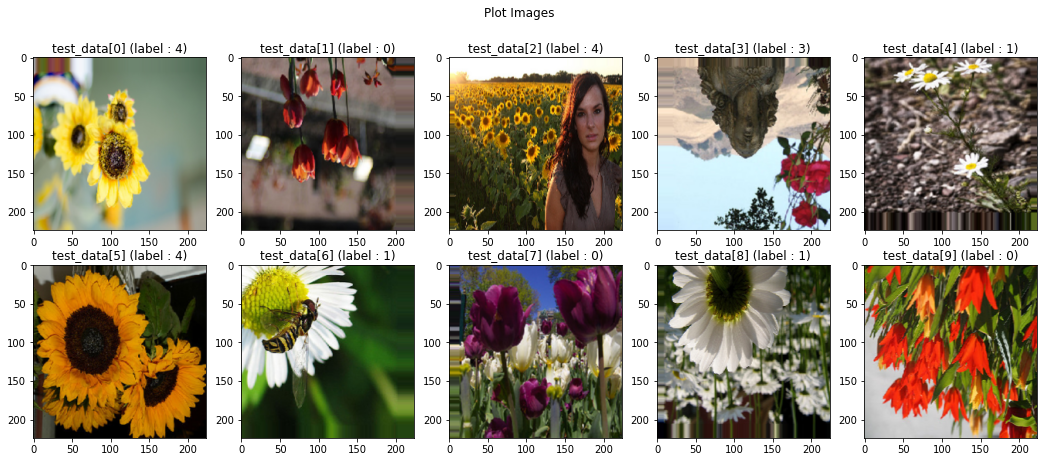

In [13]:
train_data, train_labels = next(train_data_gen)
train_labels = train_labels.astype(np.int8)
Plot_Images("Plot Images", train_data, train_labels)

## **Compile**

In [14]:
model_fine.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### Training

In [15]:
%%time
history = model_fine.fit(train_data_gen, 
                        steps_per_epoch=22,
                        epochs=20,
                        validation_data=test_data_gen,
                        validation_steps=6
                        )

Epoch 1/20
22/22 [==============================] - 223s 10s/step - loss: 0.5503 - accuracy: 0.7965 - val_loss: 0.8225 - val_accuracy: 0.8304
Epoch 2/20
22/22 [==============================] - 215s 10s/step - loss: 0.2196 - accuracy: 0.9242 - val_loss: 0.5601 - val_accuracy: 0.8591
Epoch 3/20
22/22 [==============================] - 219s 10s/step - loss: 0.1453 - accuracy: 0.9466 - val_loss: 0.4979 - val_accuracy: 0.8796
Epoch 4/20
22/22 [==============================] - 216s 10s/step - loss: 0.0962 - accuracy: 0.9655 - val_loss: 0.4879 - val_accuracy: 0.8865
Epoch 5/20
22/22 [==============================] - 215s 10s/step - loss: 0.0858 - accuracy: 0.9712 - val_loss: 0.5465 - val_accuracy: 0.8728
Epoch 6/20
22/22 [==============================] - 215s 10s/step - loss: 0.0557 - accuracy: 0.9847 - val_loss: 0.5272 - val_accuracy: 0.8495
Epoch 7/20
22/22 [==============================] - 215s 10s/step - loss: 0.0566 - accuracy: 0.9819 - val_loss: 0.5591 - val_accuracy: 0.8577
Epoch 

> ### Ploting

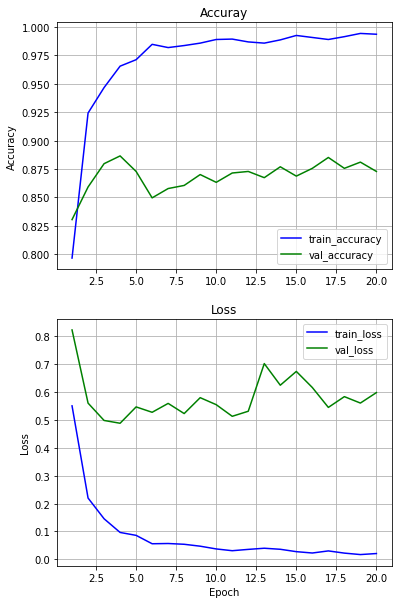

In [16]:
loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

> ### 결과 출력을 위한 함수

In [17]:
def Make_Result_Plot(suptitle, data, label, y_max):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx],cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx, label[idx], y_max[idx]))

> ### 학습 후 상황

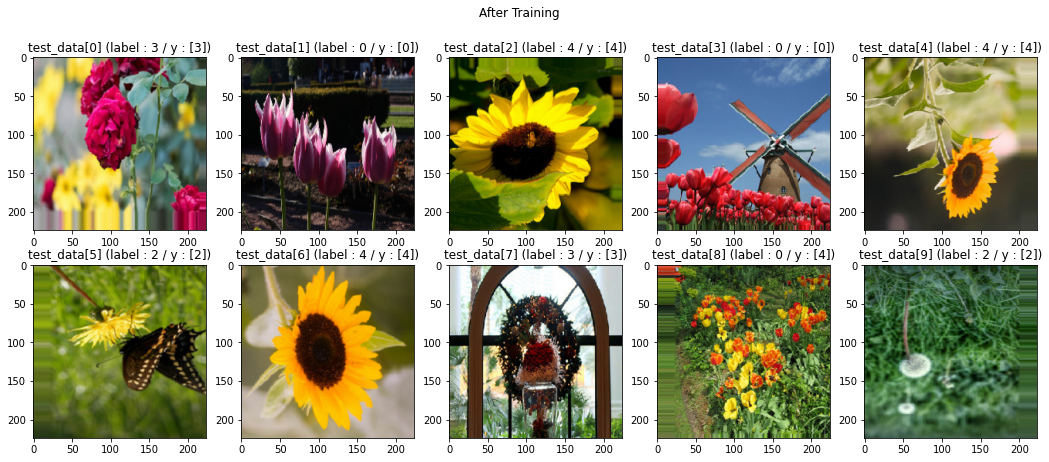

In [18]:
test_data, test_labels = next(test_data_gen)
test_labels = test_labels.astype(np.int8)
y_out = model_fine.predict(test_data)
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)